# Implementing a ResNet with the MSR Action 3D Dataset

### Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Needed imports
import sys
import math    
import os
from os.path import join
from os import listdir

import numpy as np
import cv2
from skimage import exposure

import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, Input, Flatten
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.models import Model
from keras.utils.np_utils import to_categorical
from keras.applications import ResNet50

## Importing and Preprocessing the Data

In [6]:
# 557 sequences
# three subsets: AS1, AS2, AS3
# In each category: 5 Actors for training, rest for testing
# Each data input: (joints, frames, coords)
# All coordinates are normalized
# Resize to 40x40
# Rearrange pixels: P1 --> P2 --> P3 --> P4 --> P5,
# so Joints: (8,9,19,11,23) --> (4,5,6,7,21) --> (3,2,20,1,0) --> (16,17,18,19) --> (12,13,14,15)
trainSubjects = [1,3,5,7,9]
testSubjects = [2,4,6,8,10]
groupAS1 = [2,3,5,6,10,13,18,20]
groupAS2 = [1,4,7,8,9,11,14,12]
groupAS3 = [6,14,15,16,17,18,19,20]

In [7]:
# Pad images with inter nearest interpolation to size 40x40
def pad_interpolation(input_pic):
  res = cv2.resize(input_pic, dsize=(40, 40), interpolation=cv2.INTER_NEAREST)
  return res

In [8]:
# Reorder frames as described in the paper 
def reorder_frames(action_input):
  for f in range(action_input.shape[1]):
    frame = action_input[:,f,:] # (20, 3)
    idx = [0, 7, 9,11, 1, 8, 10, 12, 19, 2, 3, 6, 4, 13, 15, 17, 5, 14, 16, 18]
    reordered_frame = frame[idx]
    action_input[:,f,:] = reordered_frame
  return action_input

In [9]:
def clean_data(input):
  zero_row = []
  for i in range(input.shape[1]):
    if (input[:,i] == np.zeros((20,3))).all():
      zero_row.append(i)

  new_seq = np.delete(input,zero_row,axis=1)
  seq_len = new_seq.shape[0]

  if np.any(new_seq) == False or seq_len < new_seq.shape[0]:
    return None
  
  return new_seq

In [10]:
# Normalize all (x,y,z) coordinates as described in the paper
def normalize(action_input):
  for f in range(action_input.shape[1]):
    frame = action_input[:,f,:] # (20, 3)
    for j in range(len(frame)):
      coords = frame[j,:]
      normed_coords = normalize_coordinates(coords,frame, action_input)
      action_input[j,f,:] = normed_coords
  action_input=np.array(action_input, dtype=np.float32)
  return action_input

In [11]:
# Normalize coordinates
def normalize_coordinates(coords,frame, action):
  min_value_x =  frame[:,0].min() 
  max_value_x = frame[:,0].max() 
  min_value_y =  frame[:,1].min() 
  max_value_y = frame[:,1].max() 
  min_value_z =  frame[:,2].min() 
  max_value_z = frame[:,2].max()
  x_norm = (coords[0] - min_value_x) / (max_value_x - min_value_x)
  y_norm = (coords[1] - min_value_y) / (max_value_y - min_value_y)
  z_norm = (coords[2] - min_value_z) / (max_value_z - min_value_z)
  return np.asarray([x_norm, y_norm, z_norm])

In [12]:
# Flip images horizontally and vertically
def augment(data_x,data_y):
  data_new_x = data_x
  data_new_y = data_y
  for idx, item in enumerate(data_x):
    # flip
    image_flipr = np.fliplr(item).reshape(1,32,32,3)
    image_flipud = np.flipud(item).reshape(1,32,32,3)

    data_new_x = np.concatenate((data_new_x, image_flipr))
    data_new_x = np.concatenate((data_new_x, image_flipud))

    data_new_y = np.concatenate((data_new_y, data_y[idx].reshape(1,8)))
    data_new_y = np.concatenate((data_new_y, data_y[idx].reshape(1,8)))
    
  return data_new_x, data_new_y

In [13]:
def equalize(action):
  action=np.array(action, dtype=np.float32)
  return exposure.equalize_adapthist(action, clip_limit=0.03)

In [14]:
def read_and_preprocess_msr_data(path, group):
  print("Reading in skeleton data...")

  labels, frame_sizes = [], []

  group_train_X, group_train_Y = [], []
  group_test_X, group_test_Y = [], []

  # Get a list of all files the right order
  file_names = sorted(listdir(path))
  files = [join(path, file) for file in file_names]

  for file in files:
    # Get the label, the subject and the number of performance from filename
    parts = file.split("/").pop().split("_")[:3]
    print(parts)
    label, subject, e = [int(x[1:].lstrip('0')) for x in parts]

    # Get only first three values (for coordinates) and not the confidence score
    action = np.loadtxt(file)[:, :3]

    # Reshape
    frame_size = len(action) // 20
    frame_sizes.append(frame_size)
    action = np.reshape(action, (20,frame_size, 3),order='F')

    # Action cleaning
    action = clean_data(action)
    if action is None:
      continue

    # Reorder
    action = reorder_frames(action)

    # Resize and pad images
    action = pad_interpolation(action)

    # Normalize
    action = normalize(action)

    # Equalize
    action = equalize(action)
    
    # Blur
    #action = cv2.GaussianBlur(action, (3, 3), 0)

    if subject in trainSubjects:
      if label in group:
        # We crop 8 times
        for i in range(0,8):
          cropped_action = action[i:i+32, i:i+32]
          group_train_X.append(cropped_action)
          group_train_Y.append(label)

    elif subject in testSubjects:
      if label in group:
        # We crop 8 times
        for i in range(0,8):
          cropped_action = action[i:i+32, i:i+32]
          group_test_X.append(cropped_action)
          group_test_Y.append(label)

  print('done')

  # Normalize values to have less classes
  uniques = list(set(group_train_Y))
  for idx, item in enumerate(group_train_Y):
    group_train_Y[idx] = uniques.index(item)

  uniques = list(set(group_test_Y))
  for idx, item in enumerate(group_test_Y):
    group_test_Y[idx] = uniques.index(item)

  # One-hot encode Y
  group_train_Y = to_categorical(group_train_Y)
  group_test_Y = to_categorical(group_test_Y)

  # Make matrix out of X --> (#samples, 32, 32, 3)
  group_train_X = np.stack(group_train_X,axis=0)
  group_test_X = np.stack(group_test_X,axis=0)
  
  # Augment data to achieve better results
  group_train_X, group_train_Y = augment(group_train_X, group_train_Y)
  group_test_X, group_test_Y = augment(group_test_X, group_test_Y)

  return group_train_X, group_train_Y, group_test_X, group_test_Y

In [ ]:
x_train, y_train, x_test, y_test = read_and_preprocess_msr_data('/content/drive/MyDrive/folder/Skeleton20Joints_unrar/', groupAS3)

In [21]:
print(f'x_train shape: {x_train.shape}, y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape}, y_test shape: {y_test.shape}')

x_train shape: (2736, 32, 32, 3), y_train shape: (2736, 8)
x_test shape: (2688, 32, 32, 3), y_test shape: (2688, 8)


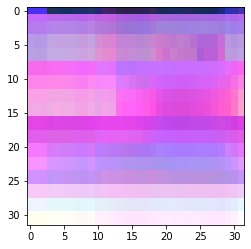

In [22]:
imshow((x_test[0]))

### ResNet Keras


In [ ]:
shape, classes = (32,32, 3), 8

x = keras.layers.Input(shape)

model = tf.keras.applications.ResNet50(input_tensor=x, classes = 8, weights = None)

model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])
#model.summary()
for i in range(10):
  model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
  _, accuracy = model.evaluate(x_test, y_test, verbose=1)
  print(f'Score: {accuracy*100.0}')


84/84 [==============================] - 1s 9ms/step - loss: 1.2550 - accuracy: 0.8415
Score: 84.15178656578064
84/84 [==============================] - 1s 9ms/step - loss: 1.2611 - accuracy: 0.8032
Score: 80.31994104385376
84/84 [==============================] - 1s 9ms/step - loss: 1.3928 - accuracy: 0.8583
Score: 85.82589030265808
84/84 [==============================] - 1s 9ms/step - loss: 1.9073 - accuracy: 0.7347
Score: 73.4747052192688
84/84 [==============================] - 1s 9ms/step - loss: 2.4941 - accuracy: 0.7816
Score: 78.1622052192688
84/84 [==============================] - 1s 9ms/step - loss: 1.1857 - accuracy: 0.8251
Score: 82.51488208770752
84/84 [==============================] - 1s 9ms/step - loss: 1.0578 - accuracy: 0.8839
Score: 88.39285969734192
84/84 [==============================] - 1s 9ms/step - loss: 1.6102 - accuracy: 0.8493
Score: 84.93303656578064
84/84 [==============================] - 1s 9ms/step - loss: 2.0130 - accuracy: 0.8579
Score: 85.788691043

## ResNet with pretrained weights 

In [ ]:
shape, classes = (32,32, 3), 8

x = keras.layers.Input(shape)

pretrained_model = tf.keras.applications.ResNet50(input_tensor=x,weights='imagenet', include_top=False)


x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(classes, activation= 'softmax')(x)
model = Model(inputs = pretrained_model.input, outputs = predictions)


model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])


for i in range(10):
  model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
  _, accuracy = model.evaluate(x_test, y_test, verbose=1)
  print(f'Score: {accuracy*100.0}')


## ResNet Implementation

In [ ]:
def lr_schedule(epoch):
  lr = 0.01
  if epoch > 74:
    lr = 0.001
  if epoch > 149:
    lr = 0.0001
  print('Learning rate: ', lr)
  return lr

In [ ]:
def resnet_layer(inputs, num_filters=16, kernel_size=3, strides=1, dropout=False, first = False):
  
  conv = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same')

  x = inputs

  if first:
    x = conv(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

  else:
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout:
      x = Dropout(rate=0.25)(x)
    x = conv(x)

  return x

In [ ]:
def resnet20(num_classes=8):
    
    num_filters = 16
    num_res_blocks = 3
    shape = (32,32, 3)
    

    inputs = Input(shape)
    x = resnet_layer(inputs=inputs, first=True)

    # Instantiate the stack of residual units
    for stack in range(3): 
        for res_block in range(num_res_blocks): # 3x 16, 3x 32, 3x 64
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,num_filters=num_filters,strides=strides)
            y = resnet_layer(inputs=y,num_filters=num_filters,dropout=True)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,num_filters=num_filters,kernel_size=1,strides=strides)
            x = keras.layers.add([x, y])
        num_filters *= 2

    # Add classifier on top.
    x = GlobalAveragePooling2D()(x)
    y = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(y)

    # Instantiate model
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
model = resnet20(8)
model.compile(loss='categorical_crossentropy',optimizer=SGD(lr=lr_schedule(0),momentum=0.9, decay=0.0001),metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
#model.summary()

In [ ]:
model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_test, y_test), callbacks=[lr_scheduler])

In [ ]:
base_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (224,224,3))


head = base_model.output
head = Flatten()(head)
head = Dropout(0.5)(head)
head = Dense(4096,activation='relu')(head)
head = Dropout(0.5)(head)
head = Dense(2048,activation='relu')(head)
head = Dropout(0.5)(head)
head = Dense(60,activation='softmax')(head)
model = Model(inputs = base_model.input, outputs = head)

#VGG16, VGG19